# I. Introduction
Sử dụng bộ dữ liệu này để tiên đoán nhưng chuyến bay trễ. Một chuyến bay bị tính là bay trễ nếu nó trễ chuyến hơn 30 phút.<br>
- Project này nên đi theo khung như các project trước.
- Ứng dụng mô hình vào Naïve Bayes, Logistic Regression, Decision Tree, Random Forest, Gradient Boosting và SVM.
- Ứng dụng PCA, SelectKBest và RFE cho kĩ thuật feature selections.
- Sử dụng gridsearchCV để thu được thông số tốt nhất cho các mô hình.
- So sánh hiệu năng giữa các model, viết phân tích tại sao mô hình này thì tốt hoặc tệ trong cách tiếp cận của thuật toán này. (Giải thích tại sao thuật toán này thì tốt hoặc tệ trong cấu trúc bộ dữ liệu, liệu có thể làm gì để cải thiện mô hình không?)
- Bao gồm những phần kết luận.

In [0]:
import pandas as pd
import numpy as np
from google.colab import auth

In [0]:
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build

In [0]:
drive_service = build('drive', 'v3')

In [0]:
request = drive_service.files().get_media(fileId = '1XQgPGGrzOU24SGcujJOZ9mPpDDfjaV4o').execute()

In [0]:
import io

In [0]:
data = pd.read_csv(io.BytesIO(request))

In [28]:
data.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,N612SW,88.0,90.0,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
data.shape

(7009728, 29)

Dữ liệu có 7009728 quan sát và 29 cột

### Check missing values

In [31]:
missing_val_count_by_column = (data.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

DepTime               136246
ArrTime               151649
TailNum                83365
ActualElapsedTime     154699
CRSElapsedTime           844
AirTime               154699
ArrDelay              154699
DepDelay              136246
TaxiIn                151649
TaxiOut               137058
CancellationCode     6872294
CarrierDelay         5484993
WeatherDelay         5484993
NASDelay             5484993
SecurityDelay        5484993
LateAircraftDelay    5484993
dtype: int64


Có nhiều cột missing value, giờ ta sẽ xem cột nào sẽ sử dụng vào mô hình, cột nào không dùng để có phương án phù hợp.

In [32]:
data.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [33]:
data.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,7009728.0,7.009728e+06,7.009728e+06,7.009728e+06,6.873482e+06,7.009728e+06,6.858079e+06,7.009728e+06,7.009728e+06,6.855029e+06,7.008884e+06,6.855029e+06,6.855029e+06,6.873482e+06,7.009728e+06,6.858079e+06,6.872670e+06,7.009728e+06,7.009728e+06,1.524735e+06,1.524735e+06,1.524735e+06,1.524735e+06,1.524735e+06
mean,2008.0,6.375130e+00,1.572801e+01,3.924182e+00,1.333830e+03,1.326086e+03,1.481258e+03,1.494801e+03,2.224200e+03,1.273224e+02,1.288668e+02,1.040186e+02,8.168452e+00,9.972570e+00,7.263870e+02,6.860852e+00,1.645305e+01,1.960618e-02,2.463006e-03,1.577206e+01,3.039031e+00,1.716462e+01,7.497434e-02,2.077098e+01
std,0.0,3.406737e+00,8.797068e+00,1.988259e+00,4.780689e+02,4.642509e+02,5.052251e+02,4.826728e+02,1.961716e+03,7.018731e+01,6.940974e+01,6.743980e+01,3.850194e+01,3.531127e+01,5.621018e+02,4.933649e+00,1.133280e+01,1.386426e-01,4.956753e-02,4.009912e+01,1.950287e+01,3.189495e+01,1.837940e+00,3.925964e+01
min,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.200000e+01,-1.410000e+02,0.000000e+00,-5.190000e+02,-5.340000e+02,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2008.0,3.000000e+00,8.000000e+00,2.000000e+00,9.280000e+02,9.250000e+02,1.107000e+03,1.115000e+03,6.220000e+02,7.700000e+01,8.000000e+01,5.500000e+01,-1.000000e+01,-4.000000e+00,3.250000e+02,4.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2008.0,6.000000e+00,1.600000e+01,4.000000e+00,1.325000e+03,1.320000e+03,1.512000e+03,1.517000e+03,1.571000e+03,1.100000e+02,1.100000e+02,8.600000e+01,-2.000000e+00,-1.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00
75%,2008.0,9.000000e+00,2.300000e+01,6.000000e+00,1.728000e+03,1.715000e+03,1.909000e+03,1.907000e+03,3.518000e+03,1.570000e+02,1.590000e+02,1.320000e+02,1.200000e+01,8.000000e+00,9.540000e+02,8.000000e+00,1.900000e+01,0.000000e+00,0.000000e+00,1.600000e+01,0.000000e+00,2.100000e+01,0.000000e+00,2.600000e+01
max,2008.0,1.200000e+01,3.100000e+01,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.400000e+03,9.743000e+03,1.379000e+03,1.435000e+03,1.350000e+03,2.461000e+03,2.467000e+03,4.962000e+03,3.080000e+02,4.290000e+02,1.000000e+00,1.000000e+00,2.436000e+03,1.352000e+03,1.357000e+03,3.920000e+02,1.316000e+03


In [34]:
data.describe(include='O')

,UniqueCarrier,TailNum,Origin,Dest,CancellationCode
count,7009728,6926363,7009728,7009728,137434
unique,20,5373,303,304,4
top,WN,N476HA,ATL,ATL,B
freq,1201754,4701,414513,414521,54904


Những dữ liệu dạng category là: Month, DayofMonth, DayOfWeek, UniqueCarrier,	TailNum,	Origin,	Dest,	CancellationCode<br>
Trong đó **target column** là **ArrDelay**, là thời gian đến trễ.<br>
Và ta không dùng các cột như Year, Cancelled,	Diverted,	CarrierDelay,	WeatherDelay,	NASDelay,	SecurityDelay,	LateAircraftDelay

### Handling Missing Values

In [35]:
# drop hàng chứa NA
data = data.dropna(subset=['DepTime', 'ArrTime', 'TailNum', \
                           'ActualElapsedTime', 'AirTime', 'ArrDelay',\
                           'DepDelay', 'TaxiIn', 'TaxiOut', ])
# drop cột không liên quan
data = data.drop(columns = ['Year', 'Diverted', 'Cancelled', 'CancellationCode', 'CarrierDelay',\
                           'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'])
# tạo cột ArrDelay_idx, DepDelay_idx mã hóa theo 1,0 với 1 là delay lớn hơn 30 phút
#data['ArrDelay_idx'] = np.where(data['ArrDelay'] >= 30, 1, 0)
# Check again
missing_val_count_by_column = (data.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


Dữ liệu giờ đã hết misssing values

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut
Month,1.000000,-0.000402,-0.005350,-0.010320,-0.008425,-0.000376,0.000353,0.005307,-0.014061,-0.006346,-0.012413,-0.042058,-0.030498,-0.005558,0.006904,-0.016249
DayofMonth,-0.000402,1.000000,0.004762,-0.001555,-0.001745,-0.001505,-0.001744,-0.000284,0.000598,0.001384,0.000950,0.001605,0.003297,0.001363,-0.002934,-0.000675
DayOfWeek,-0.005350,0.004762,1.000000,0.005660,0.005666,0.003376,0.005569,-0.001438,0.012929,0.015013,0.013915,0.010557,0.015424,0.016730,0.010243,-0.007206
DepTime,-0.010320,-0.001555,0.005660,1.000000,0.968550,0.713081,0.791431,-0.006074,-0.017070,-0.013684,-0.023170,0.178274,0.201981,-0.016523,-0.042255,0.050649
CRSDepTime,-0.008425,-0.001745,0.005666,0.968550,1.000000,0.697293,0.790820,-0.012512,-0.017184,-0.011775,-0.021086,0.116894,0.138850,-0.012189,-0.047563,0.039827
ArrTime,-0.000376,-0.001505,0.003376,0.713081,0.697293,1.000000,0.862455,-0.017674,0.037625,0.038654,0.030320,0.066020,0.073539,0.029023,0.007131,0.049582
CRSArrTime,0.000353,-0.001744,0.005569,0.791431,0.790820,0.862455,1.000000,-0.029613,0.051469,0.056582,0.044016,0.113087,0.132824,0.046195,-0.006540,0.059792
FlightNum,0.005307,-0.000284,-0.001438,-0.006074,-0.012512,-0.017674,-0.029613,1.000000,-0.319347,-0.326568,-0.334444,0.016601,0.009832,-0.348495,-0.009481,0.016576
ActualElapsedTime,-0.014061,0.000598,0.012929,-0.017070,-0.017184,0.037625,0.051469,-0.319347,1.000000,0.979875,0.984241,0.093926,0.044380,0.964521,0.158444,0.267801
CRSElapsedTime,-0.006346,0.001384,0.015013,-0.013684,-0.011775,0.038654,0.056582,-0.326568,0.979875,1.000000,0.988173,0.012642,0.035357,0.983176,0.104174,0.143128


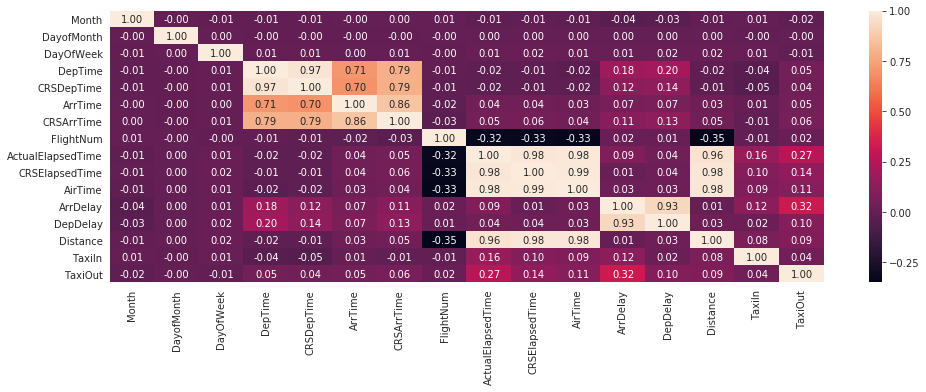

In [36]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(16,5)) 
corr = (data.corr())
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
           annot=True, fmt=".2f")
corr

Ta thấy ở tagert column ArrDelay có tương quan mạnh với DepDelay (hệ số tương quan 0.93). Nên để bài toán đặt ra thực tế hơn ta nên drop cột DepDelay

In [18]:
# tạo cột ArrDelay_idx, DepDelay_idx mã hóa theo 1,0 với 1 là delay lớn hơn 30 phút
data['ArrDelay_idx'] = np.where(data['ArrDelay'] >= 30, 1, 0)
data['ArrDelay_idx'].value_counts()

0    5927611
1     927413
Name: ArrDelay_idx, dtype: int64

dữ liệu bị imbalance, up samples và down samples không hẳn tốt,  tim thuat toan khac nhu: decision tree, naive bayes,  KNN
dieu chinh threshold >0.1 -> di khao sat
svm , logistic regression ->fail

Có 927413 chuyến đến trễ.

In [0]:
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,ArrDelay_idx
0,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0
1,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0
2,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0
3,1,3,4,926.0,930,1054.0,1100,WN,1746,N612SW,88.0,90.0,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0
4,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,1


In [0]:
# function to convert float & int format to timedelta format
def timedelta_convert(float_array):
    string_array = float_array.astype(int).astype(str).str.pad(width = 4, side = 'left', fillchar = '0') # convert to string
    minute_array = string_array.str[-2:] # get the minute part of the string
    hour_array = string_array.str[:2] # get the hour part of the string
    minute_array = pd.to_timedelta(minute_array.astype(int), unit = 'm') # turn the minute part to Timedelta format
    hour_array = pd.to_timedelta(hour_array.astype(int), unit = 'h') # turn the hour part to Timedelta format
    timedelta_array = hour_array + minute_array # join into a timedelta array
    return timedelta_array

In [0]:
# convert to timedelta format
data.DepTime = timedelta_convert(data.DepTime)
data.CRSDepTime = timedelta_convert(data.CRSDepTime)
# convert to timedelta format
data.ArrTime = timedelta_convert(data.ArrTime)
data.CRSArrTime = timedelta_convert(data.CRSArrTime)
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,ArrDelay_idx
0,1,3,4,20:03:00,19:55:00,22:11:00,22:25:00,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0
1,1,3,4,07:54:00,07:35:00,10:02:00,10:00:00,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0
2,1,3,4,06:28:00,06:20:00,08:04:00,07:50:00,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0
3,1,3,4,09:26:00,09:30:00,10:54:00,11:00:00,WN,1746,N612SW,88.0,90.0,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0
4,1,3,4,18:29:00,17:55:00,19:59:00,19:25:00,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,1


### Visualize data

**Mối quan hệ giữa ArrDelay và Month**

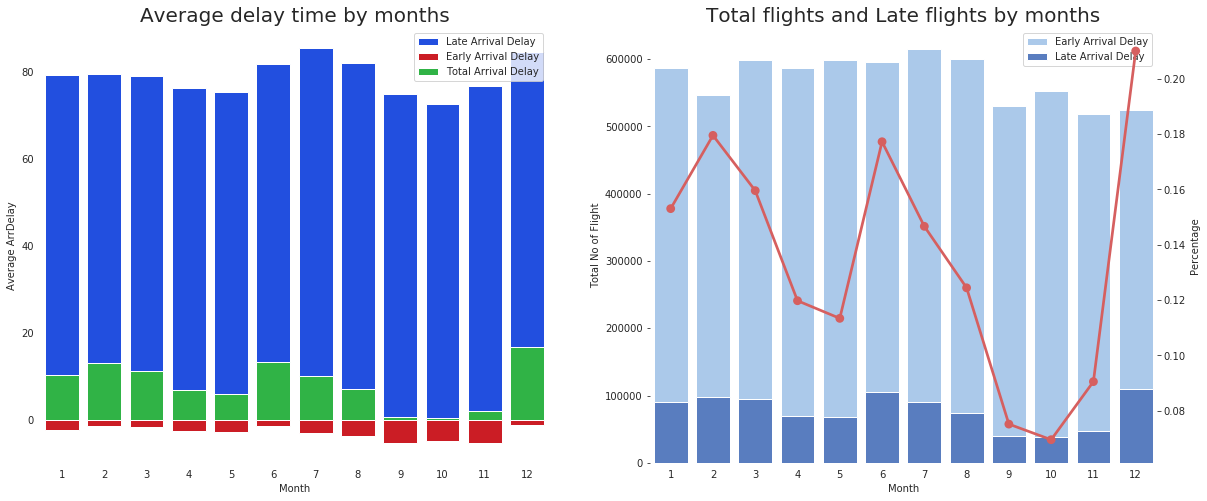

In [19]:
sns.set_style("white")
# Đồ thị thứ nhất
# data calculation
early_arrdelay_month = data[data['ArrDelay_idx'] == 0].groupby('Month').ArrDelay.mean()
early_arrdelay_month = pd.DataFrame({'Month':range(1,13),'ArrDelay':early_arrdelay_month.values})
late_arrdelay_month = data[data['ArrDelay_idx'] == 1].groupby('Month').ArrDelay.mean()
late_arrdelay_month = pd.DataFrame({'Month':range(1,13),'ArrDelay':late_arrdelay_month.values})
total_arrdelay_month = data.groupby('Month').ArrDelay.mean()
total_arrdelay_month = pd.DataFrame({'Month':range(1,13),'ArrDelay':total_arrdelay_month.values})
# set blank canvas
f, (ax, tabax) = plt.subplots(ncols=2,figsize=(20,8))
# draw
sns.set_color_codes("bright")
sns.barplot(y="ArrDelay", x="Month", data=late_arrdelay_month, label='Late Arrival Delay', color="b", orient='v', ax=ax)
sns.set_color_codes("bright")
sns.barplot(y='ArrDelay',x='Month',data=early_arrdelay_month,label='Early Arrival Delay',color='r', orient='v',ax=ax)
sns.set_color_codes("bright")
sns.barplot(y='ArrDelay',x='Month',data=total_arrdelay_month,label='Total Arrival Delay',color='g', orient='v',ax=ax)
# finalize
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylabel='Average ArrDelay')
ax.set_title('Average delay time by months', fontdict={'fontsize': 20})
ax.grid(False)
ax._frameon = False
del early_arrdelay_month
del late_arrdelay_month
del total_arrdelay_month

# Đồ thị thứ hai
# data calculate
late_arrdelay_month_count = data[data['ArrDelay_idx']==1].groupby('Month').ArrDelay.count()
late_arrdelay_month_count = pd.DataFrame({'Month':range(1,13),'ArrDelay':late_arrdelay_month_count.values})
total_arrdelay_month_count = data.groupby('Month').ArrDelay.count()
total_arrdelay_month_count = pd.DataFrame({'Month':range(1,13),'ArrDelay':total_arrdelay_month_count.values})
late_arrdelay_month_average = pd.DataFrame({'Month':range(1,13), 'Percentage':late_arrdelay_month_count.ArrDelay/total_arrdelay_month_count.ArrDelay})
# draw
sns.set_color_codes("pastel")
sns.barplot(y='ArrDelay',x='Month',data=total_arrdelay_month_count,label='Early Arrival Delay',color='b', orient='v', ax=tabax)
sns.set_color_codes("muted")
sns.barplot(y='ArrDelay',x='Month',data=late_arrdelay_month_count,label='Late Arrival Delay',color='b', orient='v', ax=tabax)
# second axis on second canvas
tabax2 = tabax.twinx()
sns.pointplot(y = 'Percentage', x='Month', data=late_arrdelay_month_average, color='r', ax=tabax2, orient='v')
#finalize
tabax.legend(ncol=1, loc="upper right", frameon=True)
tabax.set(ylabel='Total No of Flight')
tabax.set_title('Total flights and Late flights by months', fontdict={'fontsize': 20})
sns.despine(ax=tabax,left=True, bottom=True)
tabax.grid(False)
tabax._frameon = False
tabax2._frameon = False
del late_arrdelay_month_count
del total_arrdelay_month_count
del late_arrdelay_month_average
del f
del ax
del tabax
del tabax2

In [0]:
data[data['ArrDelay_idx'] == 1].groupby('Month').ArrDelay.mean()

Month
1     79.326255
2     79.410843
3     79.052986
4     76.302162
5     75.403784
6     81.827450
7     85.545623
8     82.119107
9     74.930899
10    72.500039
11    76.618796
12    84.487230
Name: ArrDelay, dtype: float64

Nhìn vào đồ thị 1 (bên trái), ta có nhận xét: 
- Các chuyến bay đến trễ thì thời gian trễ cao hơn nhiều so với thời gian của các chuyến bay đến sớm.
- Cụ thể thời gian trung bình đến trễ từ **75 phút** trở lên,  và thời gian trễ trung bình cao nhất nằm ở các tháng cao điểm **7,8,12**. Đây là thời điểm summer vacation và tháng 12 cuối năm là thời gian nghỉ đông - winter break.

Nhìn vào đồ thị 2 (bên phải), ta có nhận xét:
- Các chuyến bay tăng từ _tháng 5 đến  6_ và các chuyến bay từ các tháng cuối năm là tăng mạnh nhất từ _tháng 9 đến tháng 12_
- Các chuyến bay bị trễ nhiều nhất là tháng _2,6, 12_ và ít nhất là vào tháng 10. Vậy nếu bay vào tháng **10** thì khả năng bị trễ chuyến là thấp nhất.

**Mối quan hệ giữa ArrDelay và DayofWeek**

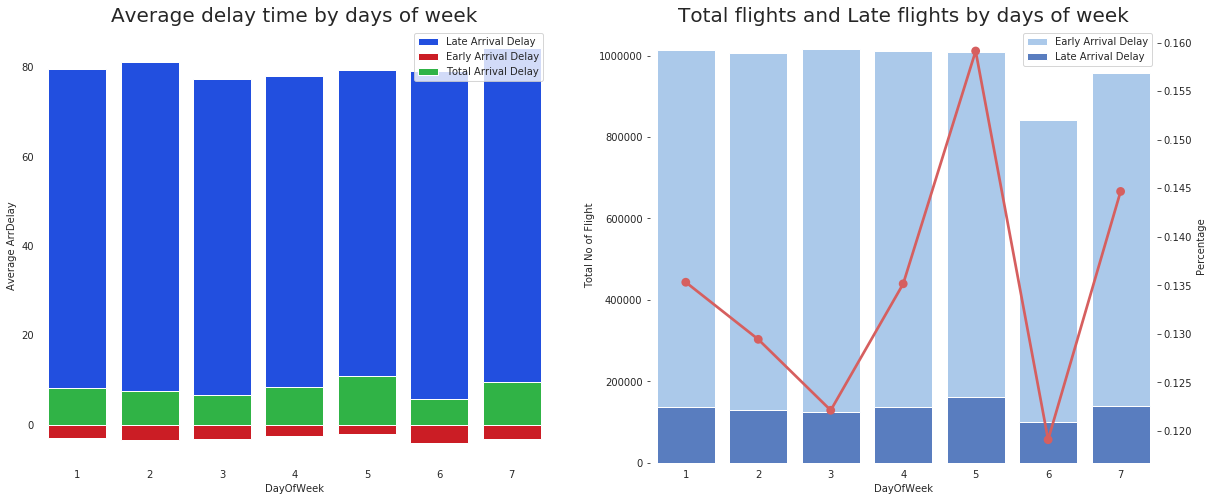

In [20]:
sns.set_style("white")
# Đồ thị thứ nhất
# data calculation
early_arrdelay_DoW = data[data['ArrDelay_idx'] == 0].groupby('DayOfWeek').ArrDelay.mean()
early_arrdelay_DoW = pd.DataFrame({'DayOfWeek': range(1,8), 'ArrDelay':early_arrdelay_DoW.values})
late_arrdelay_DoW = data[data['ArrDelay_idx'] == 1].groupby('DayOfWeek').ArrDelay.mean()
late_arrdelay_DoW = pd.DataFrame({'DayOfWeek': range(1,8), 'ArrDelay':late_arrdelay_DoW.values})
total_arrdelay_DoW = data.groupby('DayOfWeek').ArrDelay.mean()
total_arrdelay_DoW = pd.DataFrame({'DayOfWeek':range(1,8),'ArrDelay':total_arrdelay_DoW.values})
# set blank canvas
f, (ax, tabax) = plt.subplots(ncols=2,figsize=(20,8)) 
sns.set_color_codes('bright')
sns.barplot(y='ArrDelay', x='DayOfWeek', data=late_arrdelay_DoW, label='Late Arrival Delay', color='b', orient='v', ax=ax)
sns.set_color_codes('bright')
sns.barplot(y='ArrDelay',x='DayOfWeek',data=early_arrdelay_DoW,label='Early Arrival Delay',color='r', orient='v',ax=ax)
sns.set_color_codes('bright')
sns.barplot(y='ArrDelay',x='DayOfWeek', data=total_arrdelay_DoW, label='Total Arrival Delay', color='g', orient='v', ax=ax )
# finalize
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylabel='Average ArrDelay')
ax.set_title('Average delay time by days of week', fontdict={'fontsize': 20})
ax.grid(False)
ax._frameon = False
del early_arrdelay_DoW
del late_arrdelay_DoW
del total_arrdelay_DoW

# Đồ thị thứ hai
# data calculate
late_arrdelay_DoW_count = data[data.ArrDelay_idx == 1].groupby('DayOfWeek').ArrDelay.count()
late_arrdelay_DoW_count = pd.DataFrame({'DayOfWeek':range(1,8),'ArrDelay':late_arrdelay_DoW_count.values})
total_arrdelay_DoW_count = data.groupby('DayOfWeek').ArrDelay.count()
total_arrdelay_DoW_count = pd.DataFrame({'DayOfWeek':range(1,8),'ArrDelay':total_arrdelay_DoW_count.values})
late_arrdelay_DoW_average = pd.DataFrame({'DayOfWeek':range(1,8), 'Percentage':late_arrdelay_DoW_count.ArrDelay/total_arrdelay_DoW_count.ArrDelay})
# draw
sns.set_color_codes("pastel")
sns.barplot(y='ArrDelay',x='DayOfWeek',data=total_arrdelay_DoW_count,label='Early Arrival Delay',color='b', orient='v', ax=tabax)
sns.set_color_codes("muted")
sns.barplot(y='ArrDelay',x='DayOfWeek',data=late_arrdelay_DoW_count,label='Late Arrival Delay',color='b', orient='v', ax=tabax)
# second axis on second canvas
tabax2 = tabax.twinx()
sns.pointplot(y = 'Percentage', x='DayOfWeek', data=late_arrdelay_DoW_average, color='r', ax=tabax2, orient='v')
#finalize
tabax.legend(ncol=1, loc="upper right", frameon=True)
tabax.set(ylabel='Total No of Flight')
tabax.set_title('Total flights and Late flights by days of week', fontdict={'fontsize': 20})
sns.despine(ax=tabax,left=True, bottom=True)
tabax.grid(False)
tabax._frameon = False
tabax2._frameon = False
del late_arrdelay_DoW_count
del total_arrdelay_DoW_count
del late_arrdelay_DoW_average
del f
del ax
del tabax
del tabax2

In [0]:
data[data['ArrDelay_idx'] == 1].groupby('DayOfWeek').ArrDelay.mean()

DayOfWeek
1    79.502819
2    81.119315
3    77.311168
4    78.039043
5    79.477619
6    79.218047
7    84.369588
Name: ArrDelay, dtype: float64

Theo đồ thị 1 (bên trái), ta nhận thấy:
- Trong các ngày trong tuần thì thời gian bay đến trễ là gần như nhau, tronng đó  trễ cao nhất nằm ở chủ nhật là **84 phút** (index 7)
Theo đồ thị 2 (bên phải), ta nhận thấy:
- Các chuyến bay  vào thứ 7 và CN thì ít hơn các ngày trong tuần,
- Độ trễ lớn nhất nằm ở ngày thứ 6 (index 5),  và nếu bay thì tốt nhất là bay vào thứ 4 (index 3 ) và thứ 7 (index 6) thì khả năng bị delay trung bình là thấp nhất.

In [0]:
data['Distance'].describe()

count    6.855024e+06
mean     7.287441e+02
std      5.632449e+02
min      1.100000e+01
25%      3.260000e+02
50%      5.810000e+02
75%      9.540000e+02
max      4.962000e+03
Name: Distance, dtype: float64

In [0]:
# use pandas to encode 'Distance' feature by category feature
data['Distance_ctg'] = data['Distance'].apply(lambda x: 'low' if x<=326 else('medium' if 326<x<954 else 'high'))

In [0]:
data['Distance_ctg'].describe()

count     6855024
unique          3
top        medium
freq      3416196
Name: Distance_ctg, dtype: object

**Mối quan hệ giữa ArrDelay và Distance_ctg (trong đó Distance_ctg là cột đã bị encode lại để thuận tiện cho việc minh họa)**

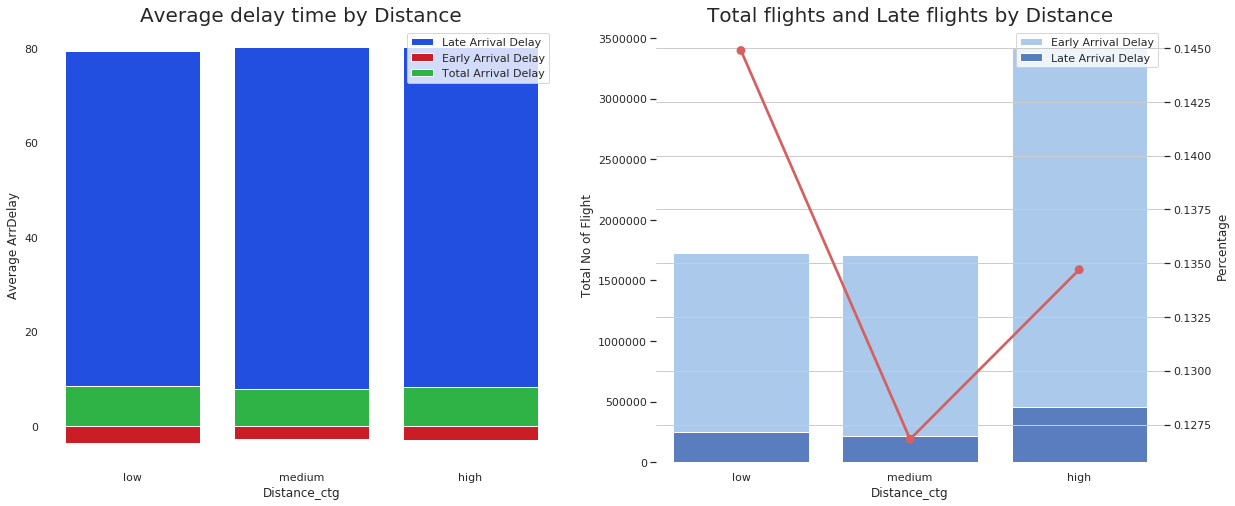

In [0]:
# Đồ thị thứ nhất
# data calculation
early_arrdelay_DoW = data[data['ArrDelay_idx'] == 0].groupby('Distance_ctg').ArrDelay.mean()
early_arrdelay_DoW = pd.DataFrame({'Distance_ctg': ['low', 'medium', 'high'], 'ArrDelay':early_arrdelay_DoW.values})
late_arrdelay_DoW = data[data['ArrDelay_idx'] == 1].groupby('Distance_ctg').ArrDelay.mean()
late_arrdelay_DoW = pd.DataFrame({'Distance_ctg': ['low', 'medium', 'high'], 'ArrDelay':late_arrdelay_DoW.values})
total_arrdelay_DoW = data.groupby('Distance_ctg').ArrDelay.mean()
total_arrdelay_DoW = pd.DataFrame({'Distance_ctg':['low', 'medium', 'high'],'ArrDelay':total_arrdelay_DoW.values})

# set blank canvas
f, (ax, tabax) = plt.subplots(ncols=2,figsize=(20,8)) 
sns.set_color_codes('bright')
sns.barplot(y='ArrDelay', x='Distance_ctg', data=late_arrdelay_DoW, label='Late Arrival Delay', color='b', orient='v', ax=ax)
sns.set_color_codes('bright')
sns.barplot(y='ArrDelay',x='Distance_ctg',data=early_arrdelay_DoW,label='Early Arrival Delay',color='r', orient='v',ax=ax)
sns.set_color_codes('bright')
sns.barplot(y='ArrDelay',x='Distance_ctg', data=total_arrdelay_DoW, label='Total Arrival Delay', color='g', orient='v', ax=ax )
# finalize
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylabel='Average ArrDelay')
ax.set_title('Average delay time by Distance', fontdict={'fontsize': 20})
ax.grid(False)
ax._frameon = False
del early_arrdelay_DoW
del late_arrdelay_DoW
del total_arrdelay_DoW

# Đồ thị thứ hai
# data calculate
late_arrdelay_DoW_count = data[data.ArrDelay_idx == 1].groupby('Distance_ctg').ArrDelay.count()
late_arrdelay_DoW_count = pd.DataFrame({'Distance_ctg':['low', 'medium', 'high'],'ArrDelay':late_arrdelay_DoW_count.values})
total_arrdelay_DoW_count = data.groupby('Distance_ctg').ArrDelay.count()
total_arrdelay_DoW_count = pd.DataFrame({'Distance_ctg':['low', 'medium', 'high'],'ArrDelay':total_arrdelay_DoW_count.values})
late_arrdelay_DoW_average = pd.DataFrame({'Distance_ctg':['low', 'medium', 'high'], 'Percentage':late_arrdelay_DoW_count.ArrDelay/total_arrdelay_DoW_count.ArrDelay})
# draw
sns.set_color_codes("pastel")
sns.barplot(y='ArrDelay',x='Distance_ctg',data=total_arrdelay_DoW_count,label='Early Arrival Delay',color='b', orient='v', ax=tabax)
sns.set_color_codes("muted")
sns.barplot(y='ArrDelay',x='Distance_ctg',data=late_arrdelay_DoW_count,label='Late Arrival Delay',color='b', orient='v', ax=tabax)
# second axis on second canvas
tabax2 = tabax.twinx()
sns.pointplot(y = 'Percentage', x='Distance_ctg', data=late_arrdelay_DoW_average, color='r', ax=tabax2, orient='v')
#finalize
tabax.legend(ncol=1, loc="upper right", frameon=True)
tabax.set(ylabel='Total No of Flight')
tabax.set_title('Total flights and Late flights by Distance', fontdict={'fontsize': 20})
sns.despine(ax=tabax,left=True, bottom=True)
tabax.grid(False)
tabax._frameon = False
tabax2._frameon = False
del late_arrdelay_DoW_count
del total_arrdelay_DoW_count
del late_arrdelay_DoW_average
del f
del ax
del tabax
del tabax2

Theo 2 đồ thị ta nhận thấy:
- Thời gian trễ ở quãng đường ngắn , trung bình và cao là gần như nhau
- Về số chuyến bay bị trễ theo quảng đường thì quãng đường ngắn có số chuyến bay đến trễ nhiều nhất còn quảng đường trung bình có số chuyến bay đến trễ thâp nhất. Nếu ta bay theo quãng đường trung bình thì khả năng bị trễ chuyến (Arrival Delay) là thấp nhất.